In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [87]:
df = pd.read_csv("../data/raw/weekly_customer_complaints.csv", index_col = "week", parse_dates=["week"])
df.index = pd.to_datetime(df.index, format = "%y-%m-%d")
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [88]:
#Info abou the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [89]:
df['complaints'] = df['complaints'].astype(str).str.replace(',', '').astype(int)

In [90]:
#Setting freq
df = df.asfreq("W-Mon")

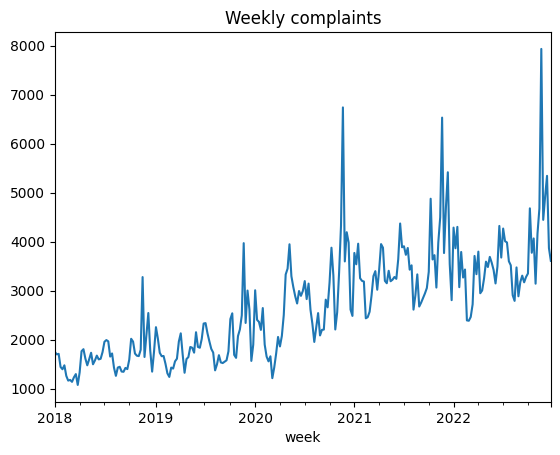

In [91]:
#EDA
df['complaints'].plot(title='Weekly complaints')
plt.show()

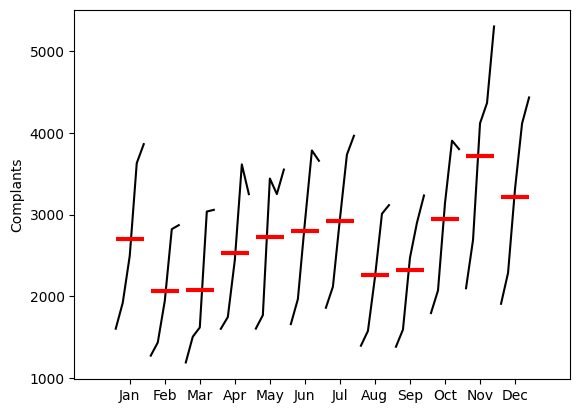

In [92]:
#ploting month seasonality
monthly_avg = df['complaints'].resample('M').mean()
month_plot(monthly_avg, ylabel = 'Complants')
plt.show()

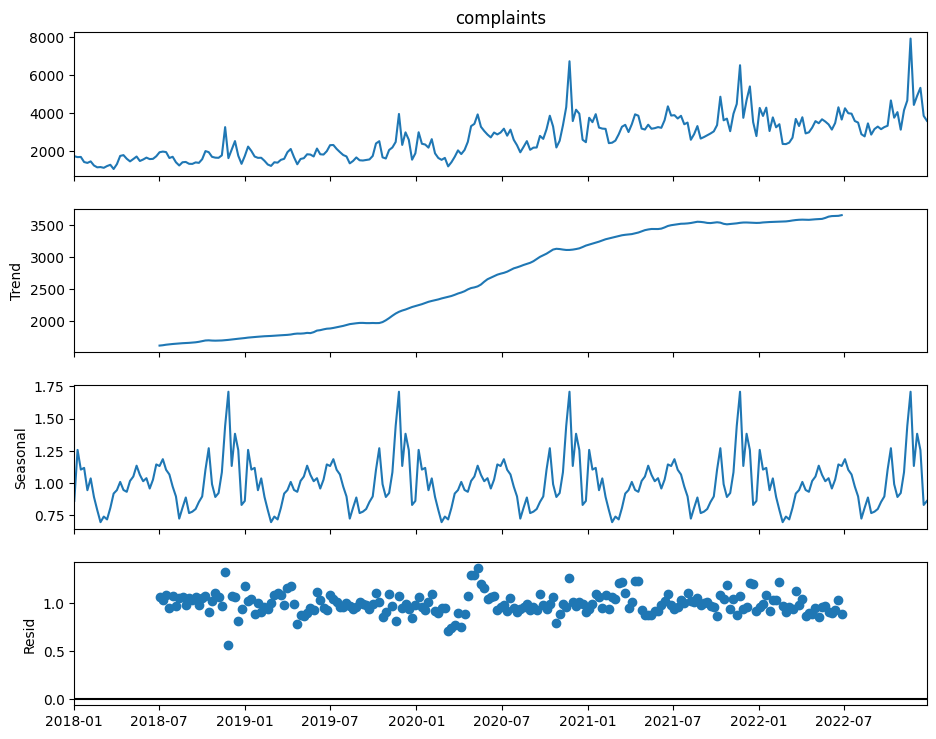

In [93]:
decomposition = seasonal_decompose(df['complaints'],
                                    model = 'mul',
                                    period=52)

fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

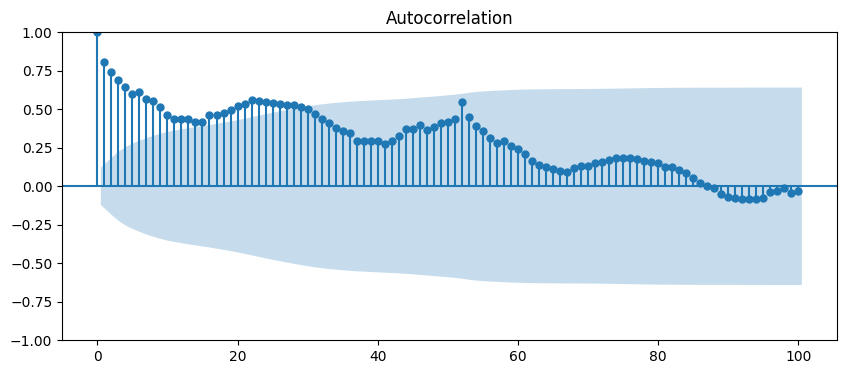

In [94]:
#Ploting auto correlation
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(df['complaints'], lags = 100 ,ax = ax)
plt.show()

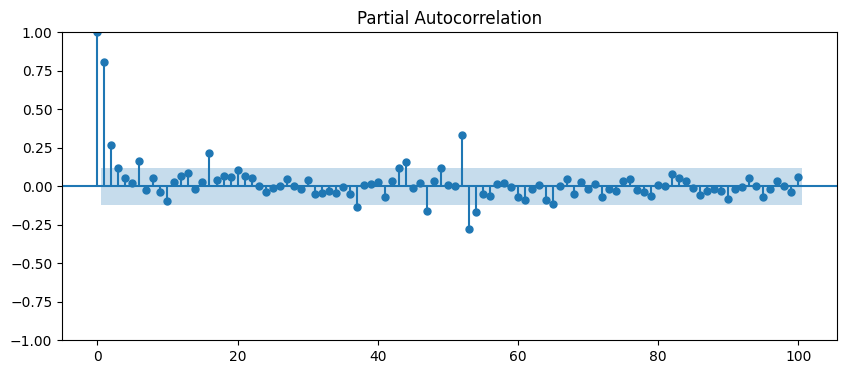

In [95]:
#Ploting partial auto correlation
fig, ax = plt.subplots(figsize = (10,4))
plot_pacf(df['complaints'], lags = 100 ,ax = ax)
plt.show()

In [96]:
#training and testing sets
#To predict next quater
#periods = 13
train, test = df.iloc[:-13,0], df.iloc[-13:,0]

In [97]:
train

week
2018-01-01    1750
2018-01-08    1701
2018-01-15    1711
2018-01-22    1443
2018-01-29    1397
              ... 
2022-08-29    2885
2022-09-05    3177
2022-09-12    3306
2022-09-19    3170
2022-09-26    3279
Freq: W-MON, Name: complaints, Length: 248, dtype: int32

In [98]:
test

week
2022-10-03    3350
2022-10-10    4679
2022-10-17    3773
2022-10-24    4065
2022-10-31    3142
2022-11-07    4164
2022-11-14    4677
2022-11-21    7931
2022-11-28    4444
2022-12-05    4920
2022-12-12    5342
2022-12-19    3868
2022-12-26    3607
Freq: W-MON, Name: complaints, dtype: int32

In [99]:
#Simple exponantial smoothing
model_simple = SimpleExpSmoothing(train).fit()
prediction_simple = model_simple.forecast(len(test))

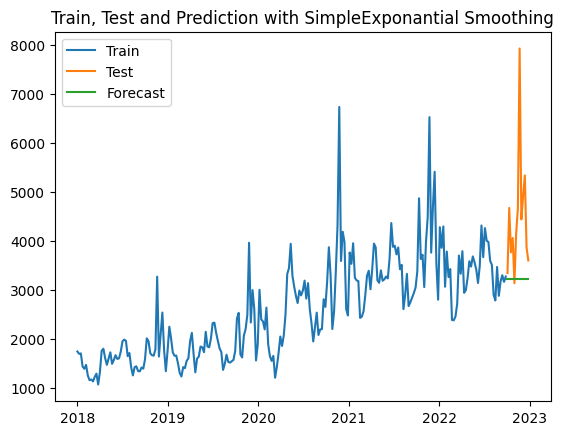

In [100]:
#Ploting training, test and forecast
plt.Figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction_simple, label='Forecast')
plt.title("Train, Test and Prediction with SimpleExponantial Smoothing")
plt.legend()
plt.show()

In [101]:
#Double exponantial smoothing
model_double = ExponentialSmoothing(train,
                                    trend= 'mul',
                                    seasonal = None).fit()

c:\Users\srmpc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [102]:
#Predictions
prediction_double = model_double.forecast(len(test))

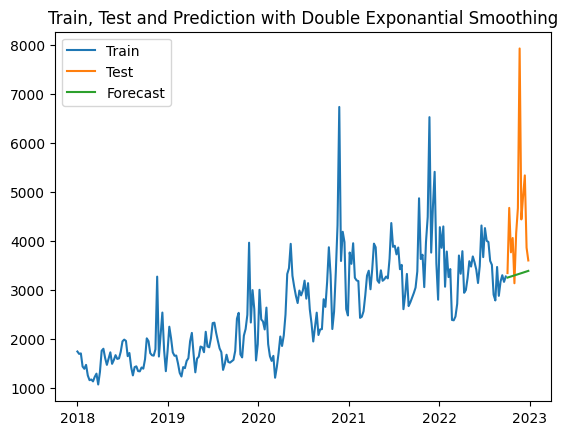

In [103]:
#Ploting training, test and forecast
plt.Figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction_double, label='Forecast')
plt.title("Train, Test and Prediction with Double Exponantial Smoothing")
plt.legend()
plt.show()

In [104]:
#Triple Exponantial Smoothing - Holt-winters
#Double exponantial smoothing
model_triple = ExponentialSmoothing(train,
                                    trend= 'add',
                                    seasonal = 'mul',
                                    seasonal_periods = 52).fit()

In [105]:
#Predictions
prediction_triple = model_triple.forecast(len(test))

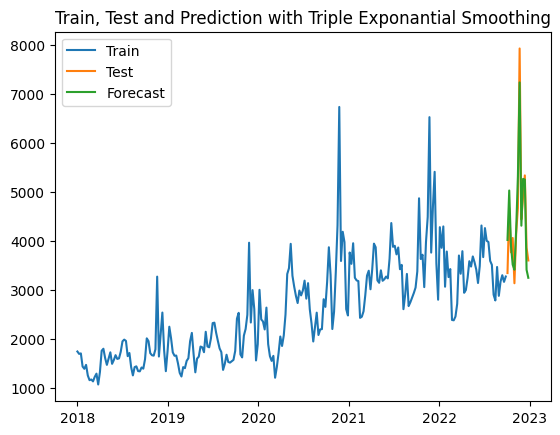

In [106]:
#Ploting training, test and forecast
plt.Figure(figsize=(10,4))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction_triple, label='Forecast')
plt.title("Train, Test and Prediction with Triple Exponantial Smoothing")
plt.legend()
plt.show()

In [107]:
#Error Metrics
#MAE, RMSE, MAPE
#Calculation error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(test, prediction_triple)
rmse = mean_squared_error(test, prediction_triple) ** 0.5
mape = mean_absolute_percentage_error(test, prediction_triple)
print(f" The MAE is {mae:.2f}")
print(f" The RMSE is {rmse:.2f}")
print(f" The MAPE is {100 * mape:.2f}%")

 The MAE is 366.14
 The RMSE is 424.83
 The MAPE is 8.52%


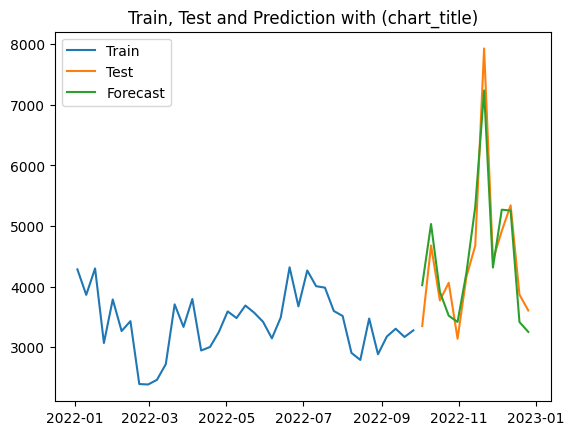

 The MAE is 366.14
 The RMSE is 424.83
 The MAPE is 8.52%


In [108]:
#function to asses model and vizualize output
def model_assesment(train, test, predictions, chart_title):
    plt.Figure(figsize=(10,4))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Forecast')
    plt.title(f"Train, Test and Prediction with (chart_title)")
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, predictions)
    rmse = mean_squared_error(test, predictions) ** 0.5
    mape = mean_absolute_percentage_error(test, predictions)
    print(f" The MAE is {mae:.2f}")
    print(f" The RMSE is {rmse:.2f}")
    print(f" The MAPE is {100 * mape:.2f}%")
    
model_assesment(train['2022':], test, prediction_triple, 'Holt_Winters')

In [110]:
#Predicting the future
#To predict the feature, including the whole data as train data
model = ExponentialSmoothing(df.complaints,
                                trend = 'add',
                                seasonal = 'mul',
                                seasonal_periods=52).fit()

forecast = model.forecast(13)
forecast

2023-01-02    4830.612817
2023-01-09    4343.461230
2023-01-16    4560.838965
2023-01-23    3690.825069
2023-01-30    4100.542668
2023-02-06    3592.651775
2023-02-13    3263.856291
2023-02-20    2737.202614
2023-02-27    2831.874772
2023-03-06    2897.676110
2023-03-13    3267.533000
2023-03-20    3745.818592
2023-03-27    3605.748068
Freq: W-MON, dtype: float64

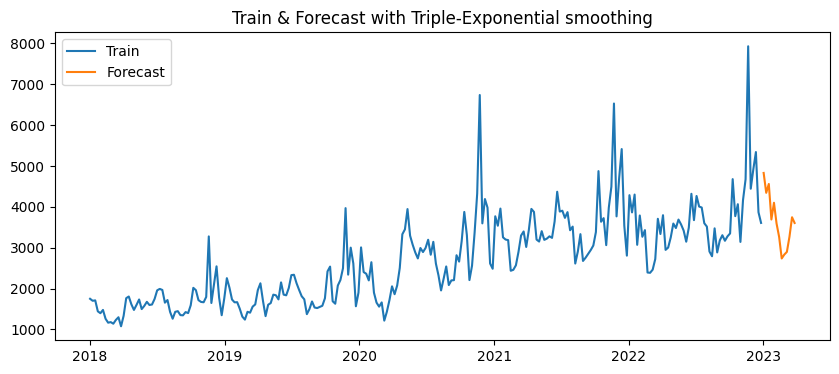

In [113]:
def plot_feature(y, forecast, title):
    plt.figure(figsize=(10,4))
    plt.plot(y, label = 'Train')
    plt.plot(forecast, label = "Forecast")
    plt.title(f"Train & Forecast with {title}")
    plt.legend()
    plt.show()
    
plot_feature(df.complaints, forecast, "Triple-Exponential smoothing")